This is analysis is based on the daily reports from the John Hopkins GitHub Repository: https://github.com/CSSEGISandData/COVID-19.

The data in the charts has been normalized both with regard to population and time. The horizontal axes are the number of days since Confirmed occurrences exceed the population for the region divided by ten million. For the linear scale charts, the vertical axes are a multiplier for each day of those occurrences on the first day. The log scale charts are the log base 10 values of the multipliers. This methodology was first proposed by Kevin Drum of Mother Jones who has kept a running account of the COVID-19 trends on his blog: https://www.motherjones.com/kevin-drum/.

The notebook is parameterized for countries, with a special case for the Hubei province in China. Add or remove names from the lists to present your charts of interest.

For a more complete listing of the available global data sources take a look at the COVID-19 dataset clearinghouse: https://asone.ai/polymath/index.php?title=COVID-19_dataset_clearinghouse.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import zipfile as zf
import math
import os

List of countries to always include

In [2]:
glob_locs = ["Italy", "Spain", "United Kingdom", "Germany"]

List of countries to always exclude:
San Marino - small country embedded in north eastern Italy
Andorra - small country between France and Spain

In [3]:
glob_locs_exclude = ["San Marino", "Andorra", "Holy See"]

Translate country location name to global population name

In [4]:
def _global_pop_name(loc):
    """
    Translate John Hopkins location name to name used in global population table
    
    Parameters
    ---------
    loc : string
        Location name
        
    Returns
    -------
    Population location name
    """
    xlator = {
        "Bolivia" : "Bolivia (Plurin. State of)",
        "Brunei" : "Brunei Darussalam",
        "Burma" : "Myanmar",
        "Congo (Brazzaville)" : "Congo",
        "Congo (Kinshasa)" : "Dem. Rep. of the Congo",
        "Iran" : "Iran (Islamic Republic of)",
        "Korea, South" : "Republic of Korea",
        "Laos" : "Lao People's Dem. Rep.",
        "Moldova" : "Republic of Moldova",
        "Russia" : "Russian Federation",
        "Saint Vincent and the Grenadines" : "Saint Vincent & Grenadines",
        "Syria" : "Syrian Arab Republic",
        "Tanzania" : "United Rep. of Tanzania",
        "Venezuela" : "Venezuela (Boliv. Rep. of)",
        "Vietnam" : "Viet Nam",
        "Britain" : "United Kingdom"
    }
    return xlator.get(loc, "")

List of provinces in China. Get the population numbers manually from: https://www.worldatlas.com/articles/chinese-provinces-by-population.html

In [5]:
cn_locs = ["Hubei"]
cn_population = {"Hubei":"57,237,740"}

Translate location name to abbreviation

In [6]:
def _loc_abbrev(loc):
    """
    Translate location name to two character abbreviation
    
    Parmaters
    ---------
    loc : string
        Location name
        
    Returns
    -------
    Two character abbreviation
    """
    xlator = {
        "United States" : "US"
    }
    return xlator.get(loc, "")

Generate list of dates

In [7]:
def _date_range(start, end):
    """
    Generate dates in the form: <dd>-<mm>-<yyyy>

    Parameters
    ----------
    start : string
        Start date in range.
    end : string
        End date in range.

    Returns
    -------
    Sequence of dates.

    """
    start_date = start.split('-')
    sdate = date(int(start_date[2]), int(start_date[0]), int(start_date[1]))
    end_date = end.split('-')
    edate = date(int(end_date[2]), int(end_date[0]), int(end_date[1]))
    
    delta = edate - sdate
    
    i = 0
    while i < delta.days + 1:
        idate = sdate + timedelta(days = i)
        day = idate.strftime("%m-%d-%Y")
        yield day
        i += 1

Extract incidents from daily reports

In [8]:
def _trend(trend_report, scope, category, locs, trend):
    """
    Parameters:
        trend_report - raw data organized by date: dictionary of dataframes
        scope - level of analysis, e.g. country (0), state (1): integer
        category - type of trend, e.g. Confirmed, Deaths, Recovered, Active: string
        locs - locations to analyze, e.g. Italy, etc.: list of strings
        trend - trend tables: dictionary of dataframes
    """
    for loc in locs:
        t = trend[category][(trend[category]['Location'] == loc)]['Threshold']
        incident_threshold = t.item()
        j = 0
        for idate in _date_range(start, end_date):
            incident_report = trend_report[idate]
            total_incidents = 0
            
            label = []
            label.append(incident_report.columns[1])
            label.append(incident_report.columns[0])
            # Early reports use 'Country/Region' and 'Province/State' column labels
            # later reports use 'Country_Region' and 'Province_State'
            if label[0] != 'Country/Region' or label[1] != 'Province/State':
                # Switch to 'Country_Region' and 'Province_State' column labels
                label[0] = incident_report.columns[3]
                label[1] = incident_report.columns[2]
                assert label[0] == "Country_Region" and label[1] == "Province_State"
                
            incident_df = incident_report[(incident_report[label[scope]] == loc)]
            
            series_loc = loc
            # Reports have changed how they list the United Kingdom
            if loc == "United Kingdom":
                if len(incident_df) == 0:
                    series_loc = "UK"
                    incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
                    
            # Reports have changed how they list South Korea
            if loc == "South Korea":
                if len(incident_df) == 0:
                    series_loc = "Republic of Korea"
                    incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
                if len(incident_df) == 0:
                    series_loc = "Korea, South"
                    incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
              
            # Early reports do not have all categories
            if incident_df.empty or category not in incident_df.columns:
                continue
            
            incidents_by_scope = incident_report.groupby([label[scope]])[category].sum()
            total_incidents = incidents_by_scope.loc[[series_loc]][0]

            try:
                # Replace state incidents with available data from CSSE US tracking
                if scope == 1 and idate in daily_us_report.keys():
                    us_day_report = daily_us_report[idate]
                    daily_series = us_day_report[(us_day_report[label[scope]] == loc)]
                    if len(daily_series) > 0 and category in daily_series.columns:
                        alt_incidents = daily_series[category].item()
                        if not np.isnan(alt_incidents):
                            total_incidents = alt_incidents
            except NameError:
                # Dataframe daily_us_report not available in this notebook
                pass
                    
            try:
                # Collect recovered data from CTP US tracking
                if category == "Recovered" and total_incidents == 0:
                    state_abbrev = _loc_abbrev(loc)
                    if len(state_abbrev) > 0 and idate in ctp_tracking.keys():
                        state_series = ctp_tracking[idate][(ctp_tracking[idate]["state"] == state_abbrev)]
                        if len(state_series) > 0:
                            recovered = state_series["recovered"].item()
                            if not np.isnan(recovered):
                                total_incidents = int(recovered)
            except NameError:
                # Dataframe ctp_tracking not available in this notebook
                pass
                
            # Many reports do not have "Active" data, ignore negative incidents
            if category == "Active" and (category not in incident_report.columns or total_incidents <= 0):
                # Calculate as: confirmed - (deaths + recovered)
                confirmed_series = trend["Confirmed"].loc[(trend["Confirmed"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                confirmed = incident_threshold * confirmed_series.item()
                deaths_series = trend["Deaths"].loc[(trend["Deaths"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                deaths = incident_threshold * deaths_series.item()
                recovered_series = trend["Recovered"].loc[(trend["Recovered"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                recovered = incident_threshold * recovered_series.item()
                total_incidents = confirmed - (deaths + recovered)

            # Record trends for all categories when Confirmed threshold is met
            tc = "Confirmed"
            cur_date = idate.split('-')
            cdate = date(int(cur_date[2]), int(cur_date[0]), int(cur_date[1]))
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) == 0:
                # Initialize the start date for category
                conf_date = trend[tc].loc[(trend[tc]['Location'] == loc), "Start Date"].item()
                if category == tc and incident_threshold < total_incidents:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = idate
                elif len(match_date) <= 0:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = conf_date
            
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) > 0:
                match_date = match_date.split('-')
                mdate = date(int(match_date[2]), int(match_date[0]), int(match_date[1]))
                if cdate >= mdate:
                    j += 1
                    trend[category].loc[(trend[category]['Location'] == loc),
                                               "Day{0:d}".format(j)] = total_incidents / incident_threshold
                    
        trend[category].loc[(trend[category]['Location'] == loc), "Last Day"] = j

Read country populations from UN. Upload the file 'SYB62_1_201907_Population,_Surface_Area_and_Density.csv' from https://data.un.org/_Docs/SYB/CSV/SYB62_1_201907_Population,%20Surface%20Area%20and%20Density.csv to the Jupyter folder containing the notebook.

In [9]:
global_population = pd.read_csv('SYB62_1_201907_Population,_Surface_Area_and_Density.csv', encoding="latin-1")

Read United States state populations from US Census. Upload the file 'nst-est2019-01.csv' from https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html to the Jupyter folder containing the notebook.

In [10]:
us_population = pd.read_csv("nst-est2019-01.csv")

Start and ending dates for reports

In [11]:
start = "01-22-2020"
end = date.today().strftime("%m-%d-%Y")

Read daily records from John Hopkins. Clone the git repository: https://github.com/CSSEGISandData/COVID-19. Zip the COVID-19\csse_covid_19_data\csse_covid_19_daily_reports directory and upload the .zip file to the Jupyter folder containing the notebook.

In [12]:
# Remove reports
report_dir = "csse_covid_19_daily_reports"
try:
    os.rmdir(report_dir)
except:
    pass
    
# Extract files from zip archive
files = zf.ZipFile("csse_covid_19_daily_reports.zip", 'r')
files.extractall("")
files.close()

days = 0
daily_report = {}
for iday in _date_range(start, end):
    try:
        daily_report[iday] = pd.read_csv("csse_covid_19_daily_reports/{}.csv".format(iday))
        end_date = iday
        days += 1
    except:
        pass
    
last_report = daily_report[end_date]

Read records from The Economist COVID-19 Daily Tracker. Clone the git repository: https://github.com/TheEconomist/covid-19-excess-deaths-tracker.git. Zip the covid-19-excess-deaths-tracker\output-data\excess-deaths directory and upload the .zip file to the Jupyter folder containing the notebook.

In [15]:
# Remove reports
report_dir = "excess-deaths"
try:
    os.rmdir(report_dir)
except:
    pass
    
# Extract files from zip archive
files = zf.ZipFile("excess-deaths.zip", 'r')
files.extractall("")
files.close()

economist_report = pd.DataFrame()
reports = os.listdir(report_dir)
for country_file in reports:
    df = pd.read_csv("{0}/{1}".format(report_dir, country_file))
    if economist_report.empty:
        economist_report = df
    else:
        economist_report = economist_report.append(df, sort = False)

Collect Economist total deaths from 2020 accumulated so far

In [16]:
economist_report_by_country = economist_report.groupby(["country"])["total_deaths"].sum()
country_list = []
for i, deaths in enumerate(economist_report_by_country):
    loc = economist_report_by_country.index[i]
    if loc == "United States":
        continue
    if loc in glob_locs_exclude:
        continue
    if loc == "Britain":
        loc = "United Kingdom"
    pop_label = _global_pop_name(loc)
    if pop_label == "":
        pop_label = loc
    pop = float(
        global_population[((global_population['Unnamed: 1'] == pop_label) &
                             (global_population['Year'] == 2019))]['Value'].iloc[0])
    country_list.append({"Location" : loc, "Deaths" : deaths, "Pop" : pop / 10.0})
# Create dataframe from list of dictionaries
country_report = pd.DataFrame(country_list)

Determine top 10 global hotspots based on total per capita deaths in Economist data.

In [17]:
# Add deaths per 10M population column
country_report["Deaths/10M"] = country_report["Deaths"] / country_report["Pop"]
country_report = country_report.sort_values("Deaths/10M", ascending = False)
# Normalize to highest
country_highest = country_report["Deaths/10M"].tolist()[0]
country_report["Normalized"] = country_report["Deaths/10M"].apply(lambda x: x / country_highest)
country_report_locs = country_report["Location"].tolist()[:20]
print(country_report_locs)

['United Kingdom', 'Spain', 'Italy', 'France', 'Chile', 'Ecuador', 'Portugal', 'Germany', 'Belgium', 'Netherlands', 'Austria', 'Sweden', 'South Africa', 'Denmark', 'Switzerland', 'Norway', 'Peru', 'Brazil', 'Turkey', 'Russia']


Determine top 20 global hotspots based on most recent per capita confirmed in John Hopkins data.

In [18]:
jh_confirmed_by_country = last_report.groupby(["Country_Region"])["Confirmed"].sum()
global_confirmed_list = []
# Update population from global data
for i, confirmed in enumerate(jh_confirmed_by_country):
    loc = jh_confirmed_by_country.keys()[i]
    if loc == "US" or loc == "Cote d'Ivoire" or loc == "Diamond Princess" \
        or loc == "Kosovo" or loc == "MS Zaandam" or loc == "Taiwan*" \
        or loc == "West Bank and Gaza":
        continue
    if loc in glob_locs_exclude:
        continue
    state = last_report["Province_State"][i]
    if loc == "United Kingdom" and state != "":
        continue
    pop_label = _global_pop_name(loc)
    if pop_label == "":
        pop_label = loc
    pop = float(
        global_population[((global_population['Unnamed: 1'] == pop_label) &
                             (global_population['Year'] == 2019))]['Value'].iloc[0])
    global_confirmed_list.append({"Location" : loc, "Confirmed" : confirmed, "Pop" : pop / 10.0})
# Create dataframe from list of dictionaries
jh_global_confirmed_report = pd.DataFrame(global_confirmed_list)
# Add contirmed per 10M population column
jh_global_confirmed_report["Confirmed/10M"] = jh_global_confirmed_report["Confirmed"] / jh_global_confirmed_report["Pop"]
jh_global_confirmed_report = jh_global_confirmed_report.sort_values("Confirmed/10M", ascending = False)
jh_country_confirmed_highest = jh_global_confirmed_report["Confirmed/10M"].tolist()[0]
jh_global_confirmed_report["Normalized"] = \
    jh_global_confirmed_report["Confirmed/10M"].apply(lambda x: x / jh_country_confirmed_highest)
print(jh_global_confirmed_report["Location"].tolist()[:20])

['Qatar', 'Bahrain', 'Israel', 'Panama', 'Peru', 'Kuwait', 'Chile', 'Brazil', 'Oman', 'Maldives', 'Armenia', 'Montenegro', 'Colombia', 'Argentina', 'Spain', 'Costa Rica', 'Luxembourg', 'Moldova', 'Bolivia', 'South Africa']


Determine top 20 global hotspots based on most recent per capita deaths in John Hopkins data.

In [19]:
jh_deaths_by_country = last_report.groupby(["Country_Region"])["Deaths"].sum()
global_deaths_list = []
# Update population from global data
for i, deaths in enumerate(jh_deaths_by_country):
    loc = jh_deaths_by_country.keys()[i]
    if loc == "US" or loc == "Cote d'Ivoire" or loc == "Diamond Princess" \
        or loc == "Kosovo" or loc == "MS Zaandam" or loc == "Taiwan*" \
        or loc == "West Bank and Gaza":
        continue
    if loc in glob_locs_exclude:
        continue
    state = last_report["Province_State"][i]
    if loc == "United Kingdom" and state != "":
        continue
    pop_label = _global_pop_name(loc)
    if pop_label == "":
        pop_label = loc
    pop = float(
        global_population[((global_population['Unnamed: 1'] == pop_label) &
                             (global_population['Year'] == 2019))]['Value'].iloc[0])
    global_deaths_list.append({"Location" : loc, "Deaths" : deaths, "Pop" : pop / 10.0})
# Create dataframe from list of dictionaries
jh_global_deaths_report = pd.DataFrame(global_deaths_list)
# Add deaths per 10M population column
jh_global_deaths_report["Deaths/10M"] = jh_global_deaths_report["Deaths"] / jh_global_deaths_report["Pop"]
jh_global_deaths_report = jh_global_deaths_report.sort_values("Deaths/10M", ascending = False)
jh_country_deaths_highest = jh_global_deaths_report["Deaths/10M"].tolist()[0]
jh_global_deaths_report["Normalized"] = \
    jh_global_deaths_report["Deaths/10M"].apply(lambda x: x / jh_country_deaths_highest)
print(jh_global_deaths_report["Location"].tolist()[:20])

['Peru', 'Belgium', 'Bolivia', 'Brazil', 'Spain', 'Chile', 'Ecuador', 'Mexico', 'Italy', 'Sweden', 'Panama', 'Colombia', 'France', 'Netherlands', 'Ireland', 'Argentina', 'North Macedonia', 'Armenia', 'Moldova', 'Iran']


Filter top 20 confirmed list

In [20]:
global_confirmed_report = jh_global_confirmed_report
global_confirmed_report = global_confirmed_report.sort_values("Normalized", ascending = False)
global_top_confirmed_locs = global_confirmed_report["Location"][:20].tolist()
global_total_confirmed_locs = global_top_confirmed_locs + glob_locs
# Remove any duplicates
global_top_confirmed_locs = list(dict.fromkeys(global_top_confirmed_locs))
global_total_confirmed_locs = list(dict.fromkeys(global_total_confirmed_locs))
print(global_top_confirmed_locs)

['Qatar', 'Bahrain', 'Israel', 'Panama', 'Peru', 'Kuwait', 'Chile', 'Brazil', 'Oman', 'Maldives', 'Armenia', 'Montenegro', 'Colombia', 'Argentina', 'Spain', 'Costa Rica', 'Luxembourg', 'Moldova', 'Bolivia', 'South Africa']


Combine two top 10 deaths lists

In [21]:
global_deaths_report = pd.concat([country_report, jh_global_deaths_report])
global_deaths_report = global_deaths_report.sort_values("Normalized", ascending = False)
global_top_deaths_locs = global_deaths_report["Location"][:30].tolist()
global_total_deaths_locs = global_top_deaths_locs + glob_locs
# Remove any duplicates
global_top_deaths_locs = list(dict.fromkeys(global_top_deaths_locs))
global_total_deaths_locs = list(dict.fromkeys(global_total_deaths_locs))
print(global_top_deaths_locs)

['United Kingdom', 'Peru', 'Belgium', 'Spain', 'Bolivia', 'Brazil', 'Chile', 'Ecuador', 'Italy', 'Mexico', 'Sweden', 'France', 'Panama', 'Colombia', 'Portugal', 'Netherlands', 'Ireland', 'Argentina', 'Germany', 'North Macedonia', 'Armenia', 'Moldova', 'Austria']


In [22]:
empty_date = '1990-01-01'

Data frame for confirmed locations with global incident thresholds (per 10 million population) followed by placeholders for daily numbers

In [23]:
global_confirmed_trend = {}
global_confirmed_trend['Confirmed'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_confirmed_trend['Deaths'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_confirmed_trend['Recovered'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_confirmed_trend['Active'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
i = 0
for loc in global_total_confirmed_locs:
    pop_label = _global_pop_name(loc)
    if pop_label == "":
        pop_label = loc
    pop = float(
        global_population[((global_population['Unnamed: 1'] == pop_label) &
                             (global_population['Year'] == 2019))]['Value'].iloc[0])
    global_confirmed_trend['Confirmed'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_confirmed_trend['Deaths'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_confirmed_trend['Recovered'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_confirmed_trend['Active'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    i += 1

Data frame for deaths locations with global incident thresholds (per 10 million population) followed by placeholders for daily numbers

In [24]:
global_deaths_trend = {}
global_deaths_trend['Confirmed'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_deaths_trend['Deaths'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_deaths_trend['Recovered'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
global_deaths_trend['Active'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
i = 0
for loc in global_total_deaths_locs:
    pop_label = _global_pop_name(loc)
    if pop_label == "":
        pop_label = loc
    pop = float(
        global_population[((global_population['Unnamed: 1'] == pop_label) &
                             (global_population['Year'] == 2019))]['Value'].iloc[0])
    global_deaths_trend['Confirmed'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_deaths_trend['Deaths'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_deaths_trend['Recovered'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    global_deaths_trend['Active'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    i += 1

Data frame with China province incident threshholds (per 10 million population) followed by placeholders for daily numbers

In [25]:
cn_trend = {}
cn_trend['Confirmed'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', 'Last Day'] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
cn_trend['Deaths'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
cn_trend['Recovered'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
cn_trend['Active'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
i = 0
for loc in cn_locs:
    pop = cn_population[loc]
    # Remove commas and divide by one million
    pop = float(pop.replace(',','')) / 10**6
    cn_trend['Confirmed'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    cn_trend['Deaths'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    cn_trend['Recovered'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    cn_trend['Active'].loc[i] = [loc] + [pop/10.0] + [""] + [0] + [0.0 for i in range(days)]
    i += 1

Data frame with United States incident thresholds (per 10 million population) followed by placeholders for daily numbers

In [26]:
def _add_row(days, us_population, us_incidents, i, loc):
    global global_population
    search_loc = loc
    if i > 0:
        search_loc = '.' + loc
    if loc == "US":
        pop = float(
            global_population[((global_population['Unnamed: 1'] == "United States of America") &
                                 (global_population['Year'] == 2019))]['Value'].iloc[0])
    else:
        pop = us_population[(us_population['Geographic Area'] == search_loc)]['2019'].iloc[0]
        # Remove commas and divide by one million
        pop = float(pop.replace(',','')) / 10**6
    us_incidents.loc[i] = [loc] + [pop /10.0] + [""] + [0] + [0.0 for i in range(days)]

In [27]:
us_trend = {}
us_trend['Confirmed'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
us_trend['Deaths'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
us_trend['Recovered'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
us_trend['Active'] = pd.DataFrame(None, columns = ['Location', 'Threshold', 'Start Date', "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
i = 0
_add_row(days, us_population, us_trend['Confirmed'], i, "US")
_add_row(days, us_population, us_trend['Deaths'], i, "US")
_add_row(days, us_population, us_trend['Recovered'], i, "US")
_add_row(days, us_population, us_trend['Active'], i, "US")

Global confirmed location incidents

In [28]:
_trend(daily_report, 0, 'Confirmed', global_total_confirmed_locs, global_confirmed_trend)
_trend(daily_report, 0, 'Deaths', global_total_confirmed_locs, global_confirmed_trend)
_trend(daily_report, 0, 'Recovered', global_total_confirmed_locs, global_confirmed_trend)
_trend(daily_report, 0, 'Active', global_total_confirmed_locs, global_confirmed_trend)

Global deaths location incidents

In [29]:
_trend(daily_report, 0, 'Confirmed', global_total_deaths_locs, global_deaths_trend)
_trend(daily_report, 0, 'Deaths', global_total_deaths_locs, global_deaths_trend)
_trend(daily_report, 0, 'Recovered', global_total_deaths_locs, global_deaths_trend)
_trend(daily_report, 0, 'Active', global_total_deaths_locs, global_deaths_trend)

China province incidents

In [28]:
_trend(daily_report, 1, 'Confirmed', cn_locs, cn_trend)
_trend(daily_report, 1, 'Deaths', cn_locs, cn_trend)
_trend(daily_report, 1, 'Recovered', cn_locs, cn_trend)
_trend(daily_report, 1, 'Active', cn_locs, cn_trend)

United States incidents

In [29]:
_trend(daily_report, 0, 'Confirmed', ["US"], us_trend)
_trend(daily_report, 0, 'Deaths', ["US"], us_trend)
_trend(daily_report, 0, 'Recovered', ["US"], us_trend)
_trend(daily_report, 0, 'Active', ["US"], us_trend)

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import statistics

In [31]:
def _subplot_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_df = df.loc[(df["Location"] == loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        y.append(daily)
    x = [j+1 for j in range(len(y))]
    if loc in country_report_locs:
        loc += "*"
    if len(x) > 0:
        plt.text(x[-1], y[-1], loc)
    label = "{0} - {1}".format(start_date, loc)
    plt.plot(x, y, line_style, c = color, label = label)

In [32]:
def _subplot_log_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_df = df.loc[(df["Location"] == loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        if daily <= 0.0:
            daily = np.nan
        y.append(math.log(daily, 10))
    y = pd.Series(y).fillna(method = 'ffill').to_list()
    x = [j+1 for j in range(len(y))]
    if loc in country_report_locs:
        loc += "*"
    if len(x) > 0 and not np.isnan(y[-1]):
        plt.text(x[-1], y[-1], loc)
    label = "{0} - {1}".format(start_date, loc)
    plt.plot(x, y, line_style, c = color, label = label)

In [33]:
def _plot_trend(db, locs, category, leg_loc = "upper left"):
    """
    Parameters:
        db - dictionary of data frames
        locs - list of locations
        category - incident type
        leg_loc - legend placement
    """
    plt.figure(figsize = (20,12))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(locs) + 3)))
    color = next(colors)
    _subplot_trend(plt, cn_trend[category], "Hubei", color, '--')
    color = next(colors)
    _subplot_trend(plt, db[category], "Italy", color, '--')
    color = next(colors)
    _subplot_trend(plt, us_trend[category], "US", color, '--')
    for loc in locs:
        if loc == "Italy":
            continue
        color = next(colors)
        _subplot_trend(plt, db[category], loc, color, '-.')

    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Linear Growth of Number of {} per 10M population".format(category))

In [34]:
def _plot_log_trend(db, locs, category, leg_loc = "lower right"):
    plt.figure(figsize=(20,12))
    colors = iter(cm.rainbow(np.linspace(0,1,len(locs) + 3)))
    color = next(colors)
    _subplot_log_trend(plt, cn_trend[category], "Hubei", color, '--')
    color = next(colors)
    _subplot_log_trend(plt, db[category], "Italy", color, '--')
    color = next(colors)
    _subplot_log_trend(plt, us_trend[category], "US", color, '--')
    for loc in locs:
        if loc == "Italy":
            continue
        color = next(colors)
        _subplot_log_trend(plt, db[category], loc, color, '-.')
        
    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Log Growth of Number of {} per 10M population".format(category))

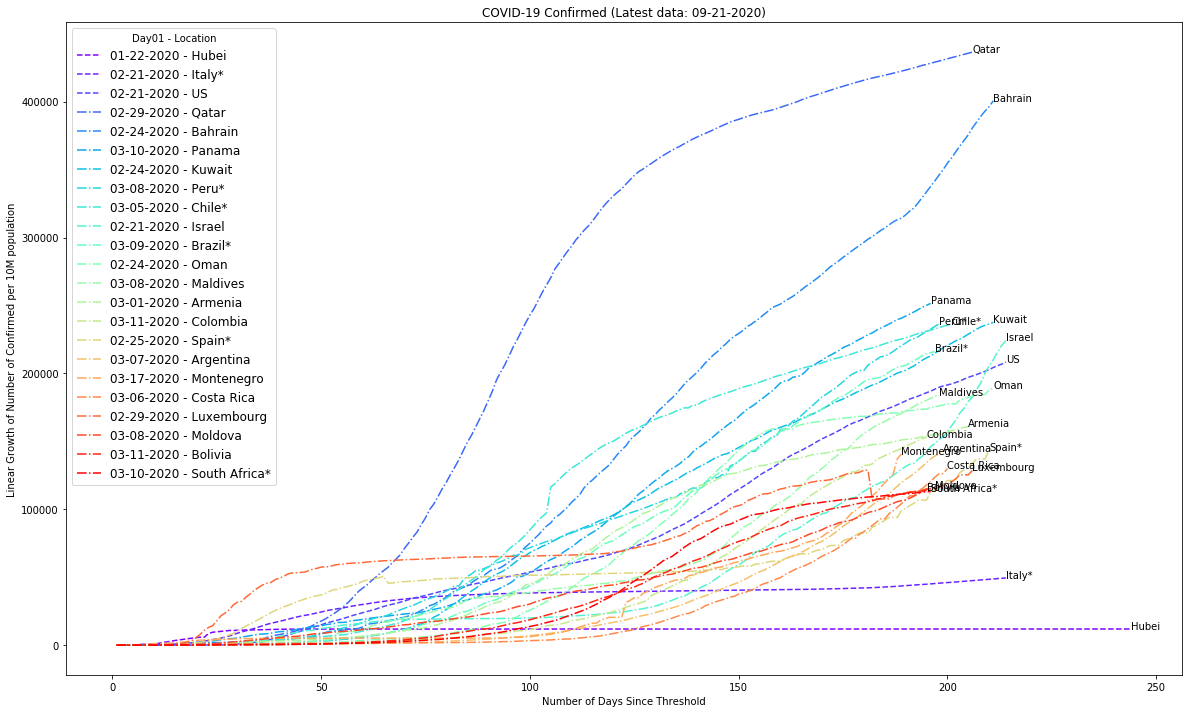

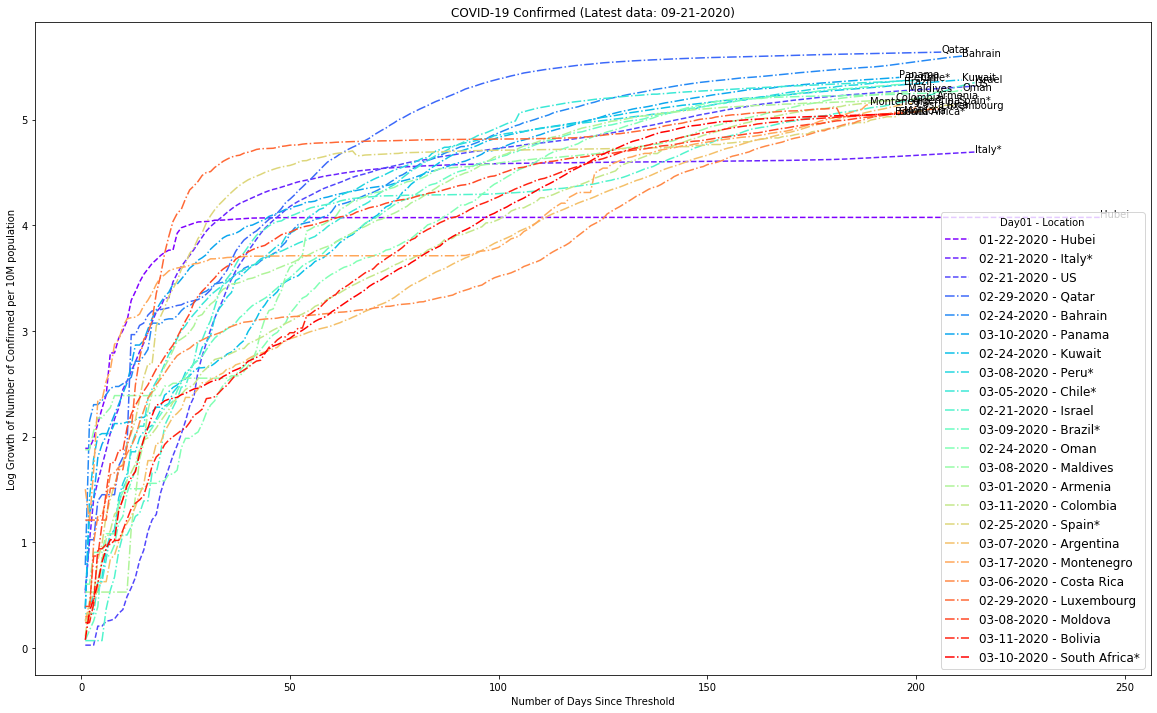

In [35]:
_plot_trend(global_confirmed_trend, global_top_confirmed_locs, 'Confirmed')
_plot_log_trend(global_confirmed_trend, global_top_confirmed_locs, 'Confirmed')

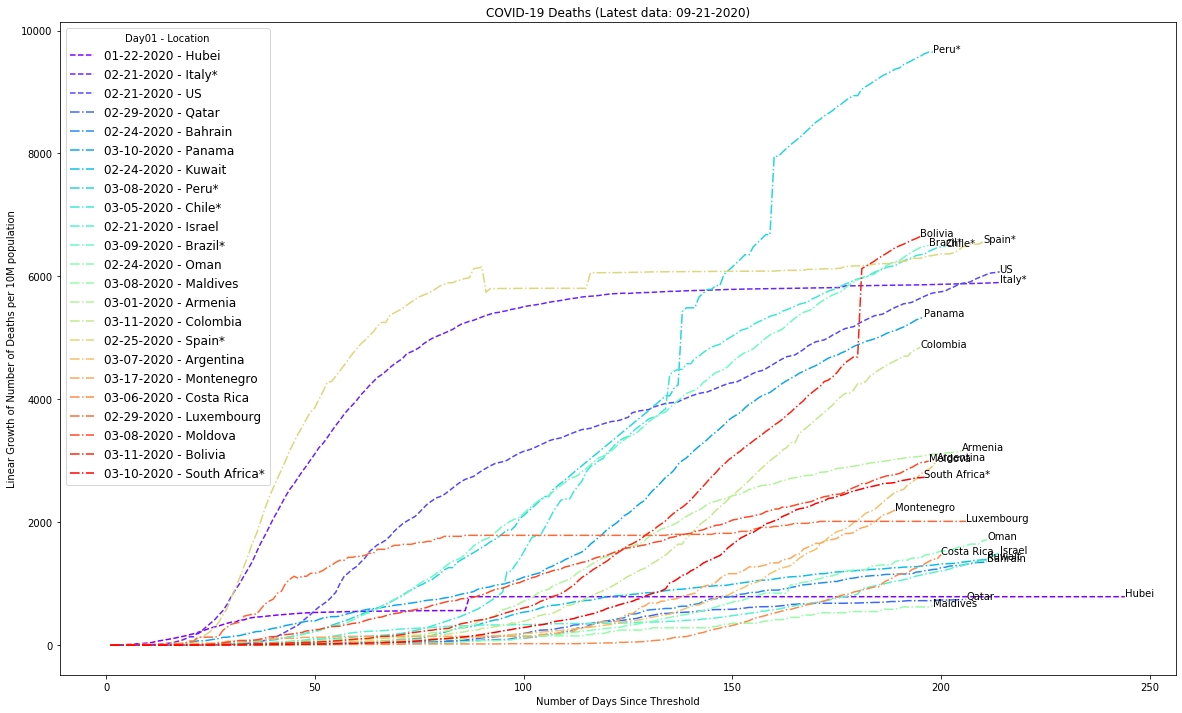

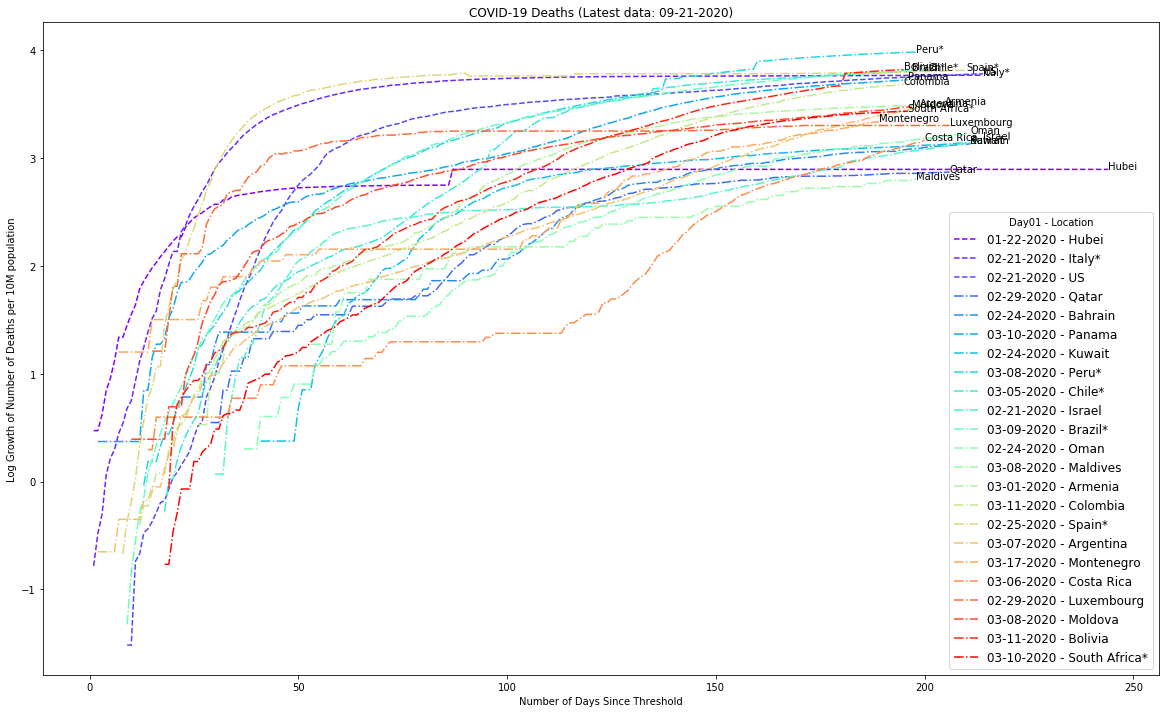

In [36]:
_plot_trend(global_confirmed_trend, global_top_confirmed_locs, 'Deaths')
_plot_log_trend(global_confirmed_trend, global_top_confirmed_locs, 'Deaths')

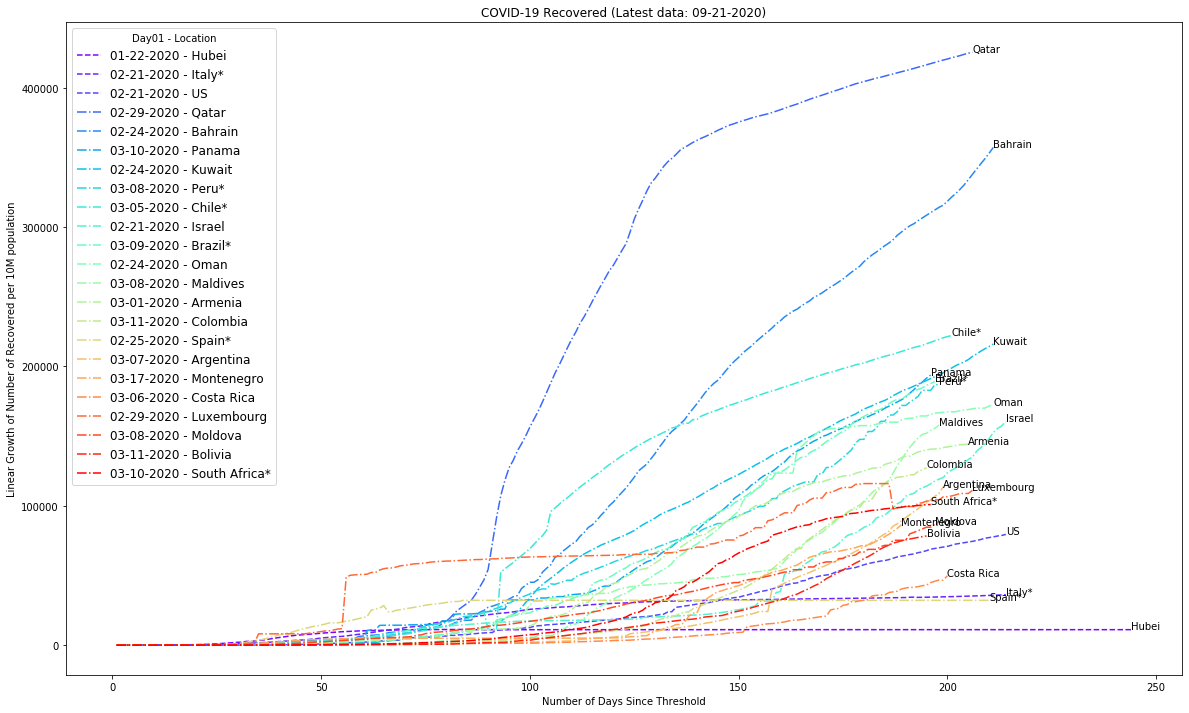

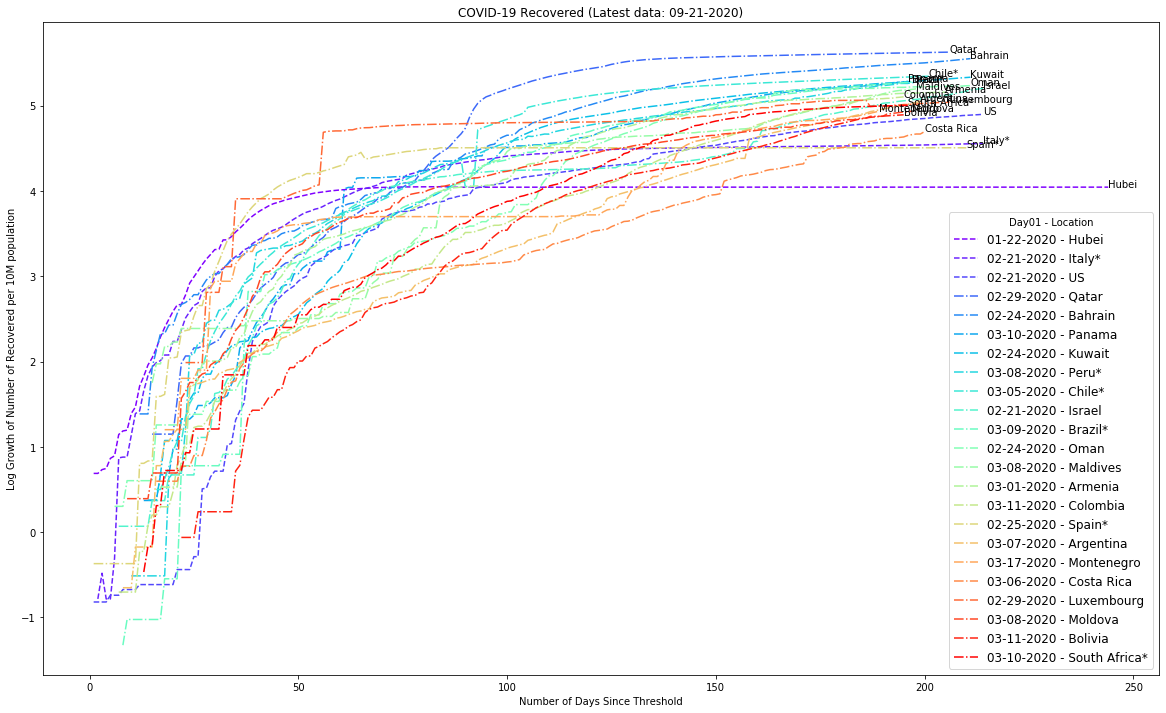

In [37]:
_plot_trend(global_confirmed_trend, global_top_confirmed_locs, 'Recovered')
_plot_log_trend(global_confirmed_trend, global_top_confirmed_locs, 'Recovered')

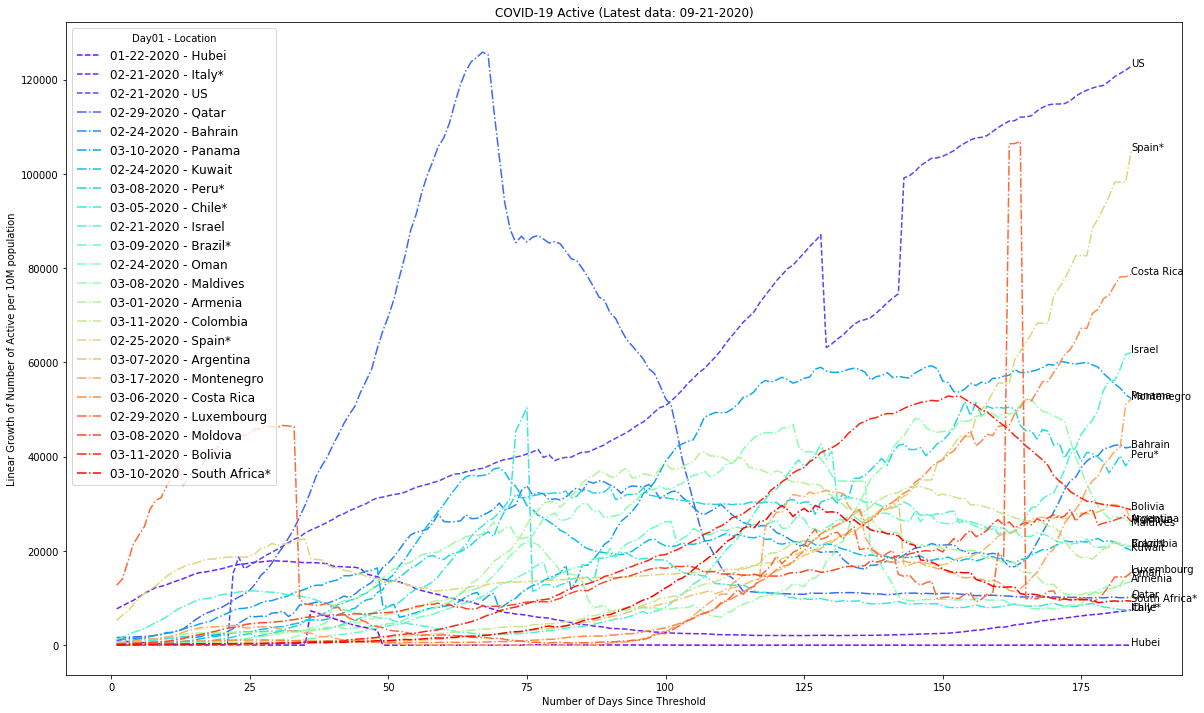

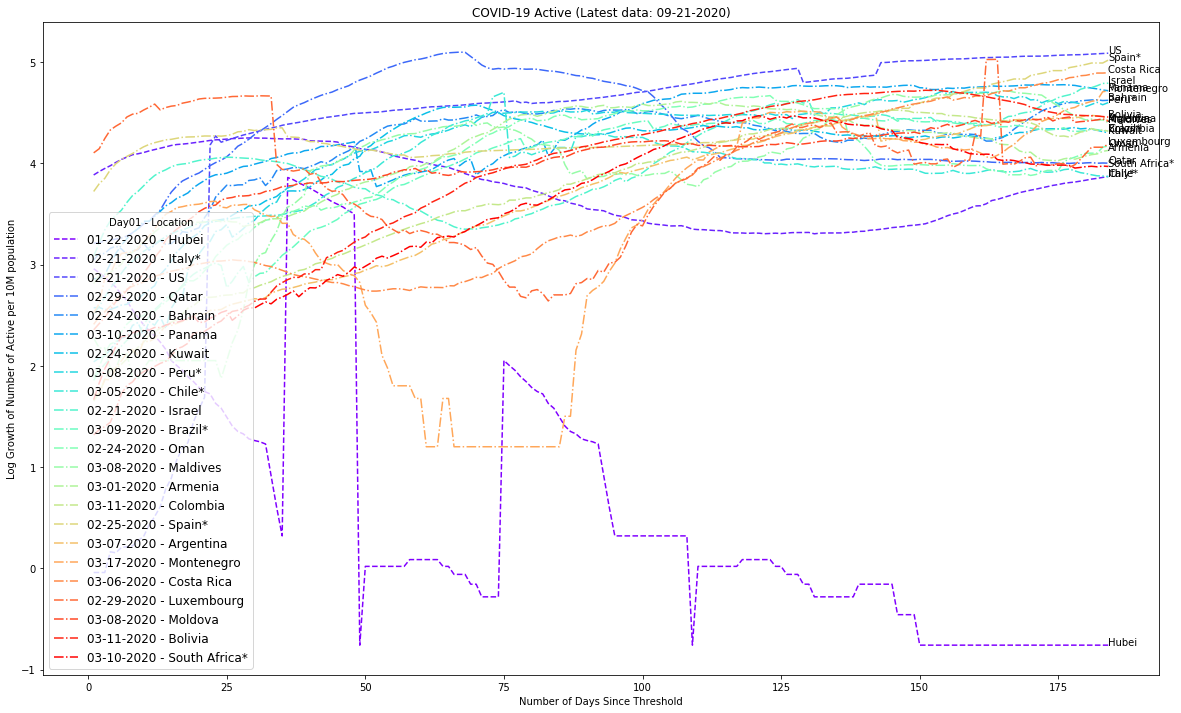

In [38]:
_plot_trend(global_confirmed_trend, global_top_confirmed_locs, 'Active')
_plot_log_trend(global_confirmed_trend, global_top_confirmed_locs, 'Active', leg_loc = "lower left")

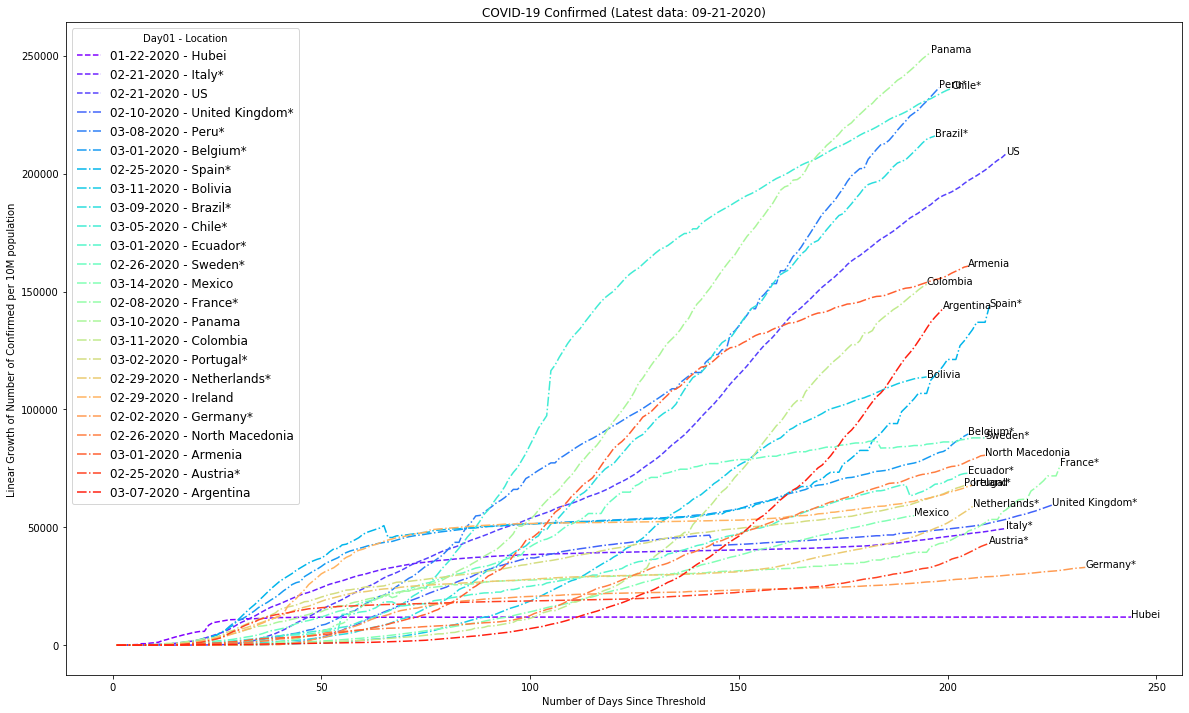

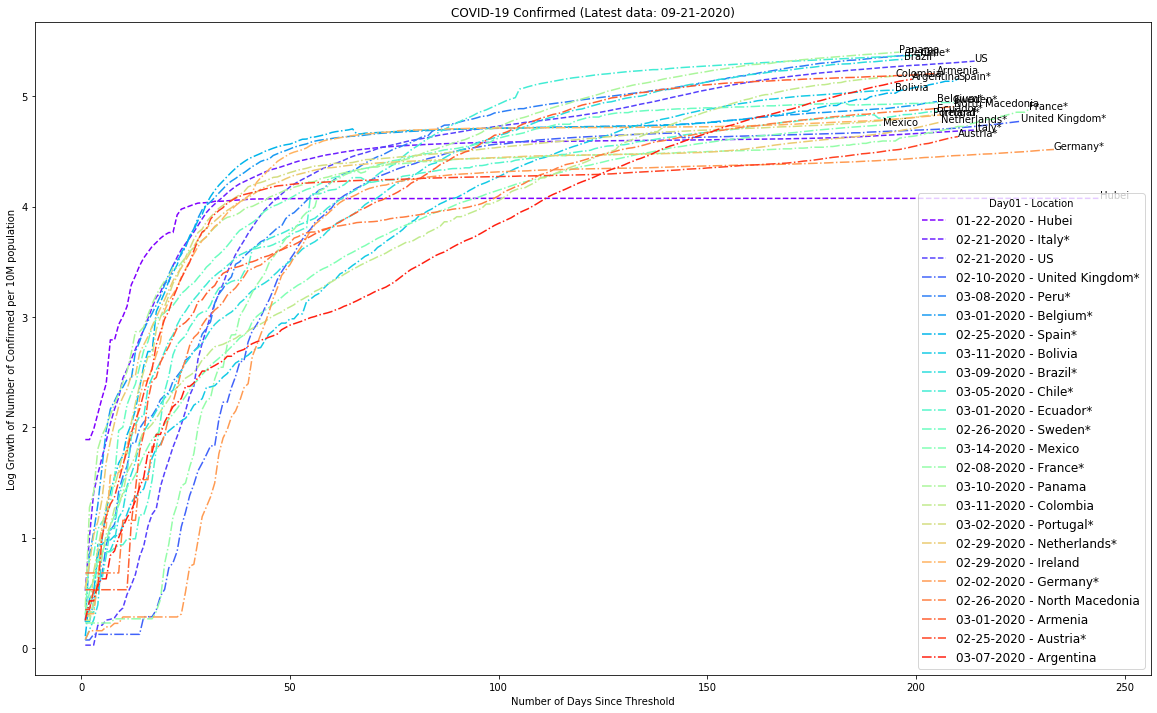

In [39]:
_plot_trend(global_deaths_trend, global_top_deaths_locs, 'Confirmed')
_plot_log_trend(global_deaths_trend, global_top_deaths_locs, 'Confirmed')

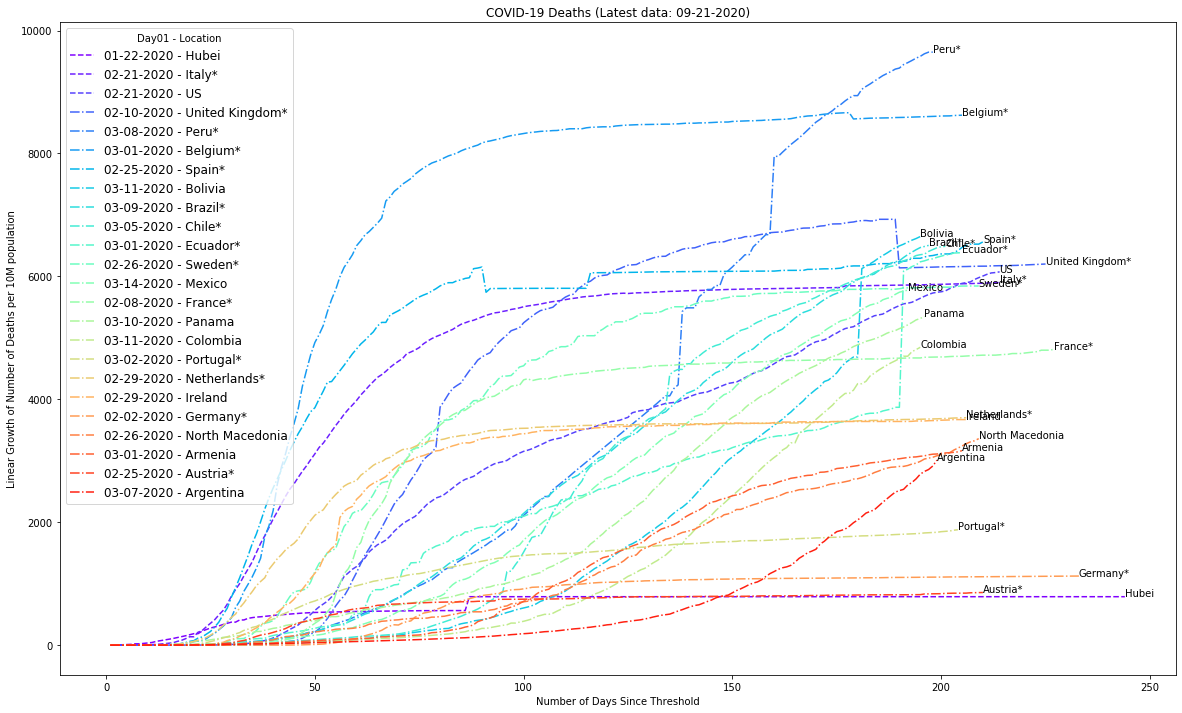

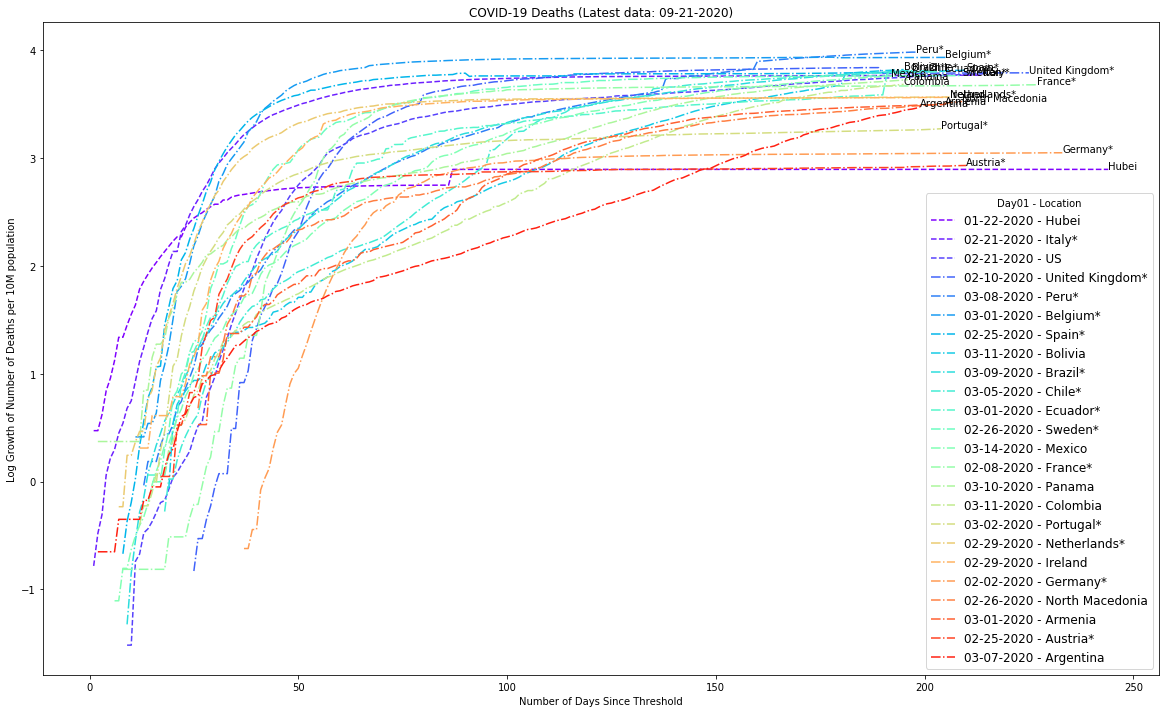

In [40]:
_plot_trend(global_deaths_trend, global_top_deaths_locs, 'Deaths')
_plot_log_trend(global_deaths_trend, global_top_deaths_locs, 'Deaths')

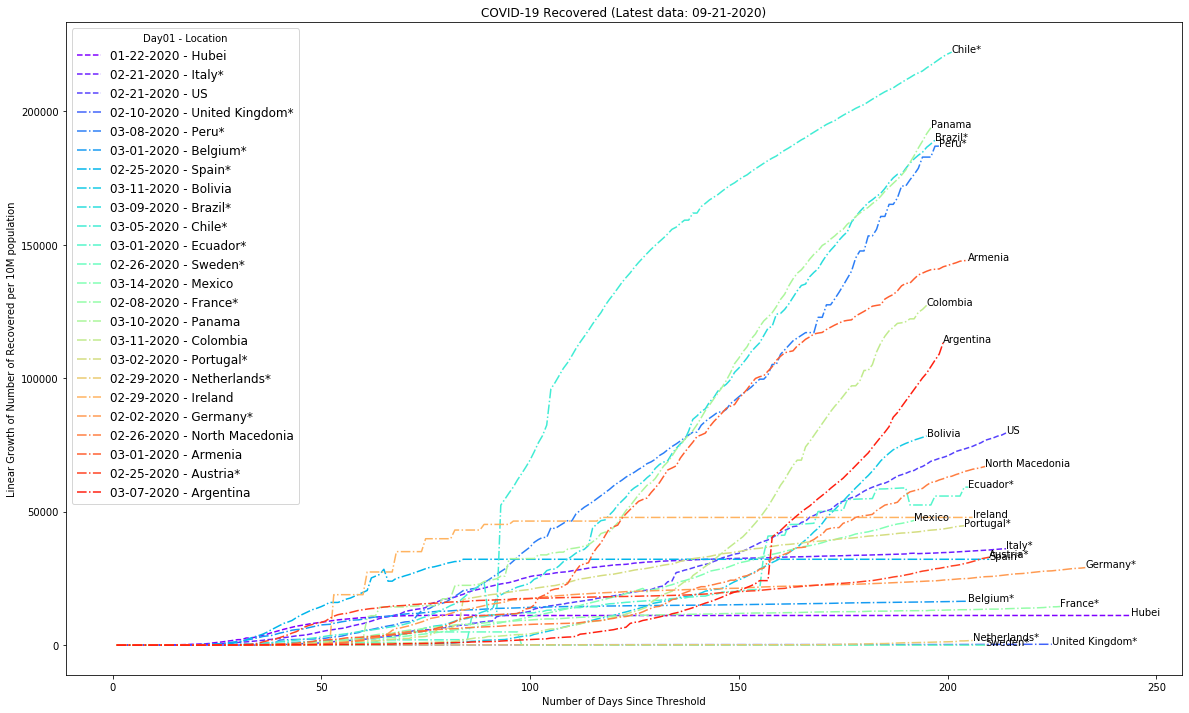

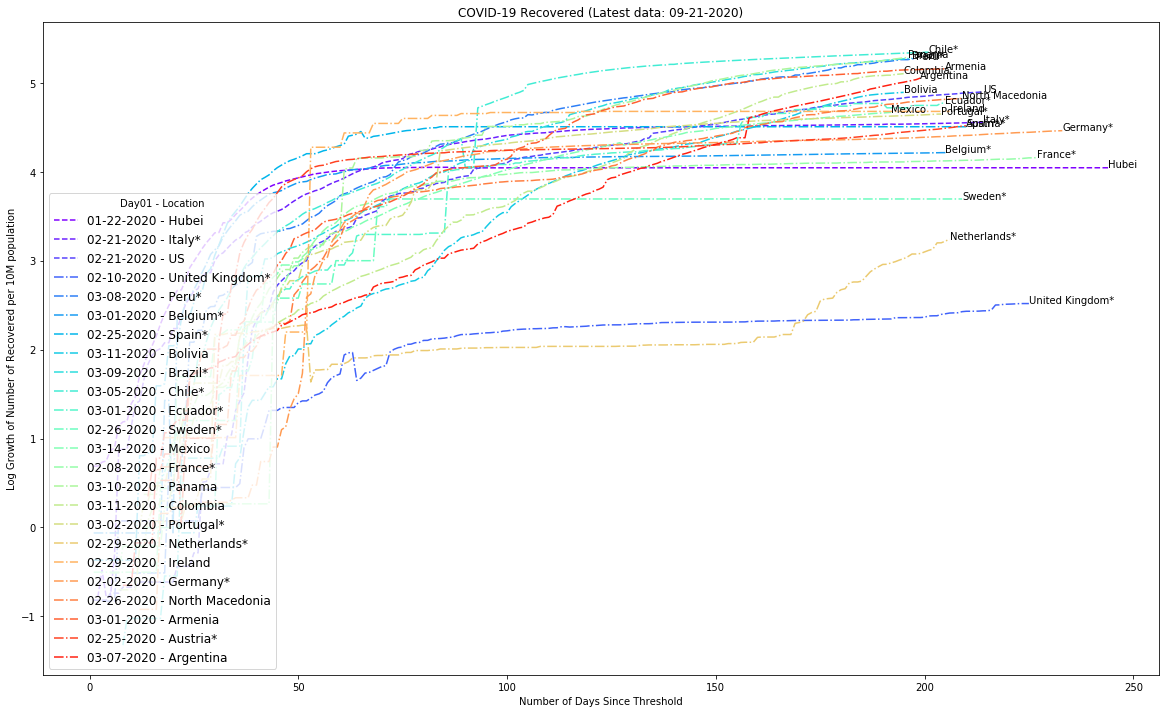

In [41]:
_plot_trend(global_deaths_trend, global_top_deaths_locs, 'Recovered')
_plot_log_trend(global_deaths_trend, global_top_deaths_locs, 'Recovered', leg_loc = "lower left")

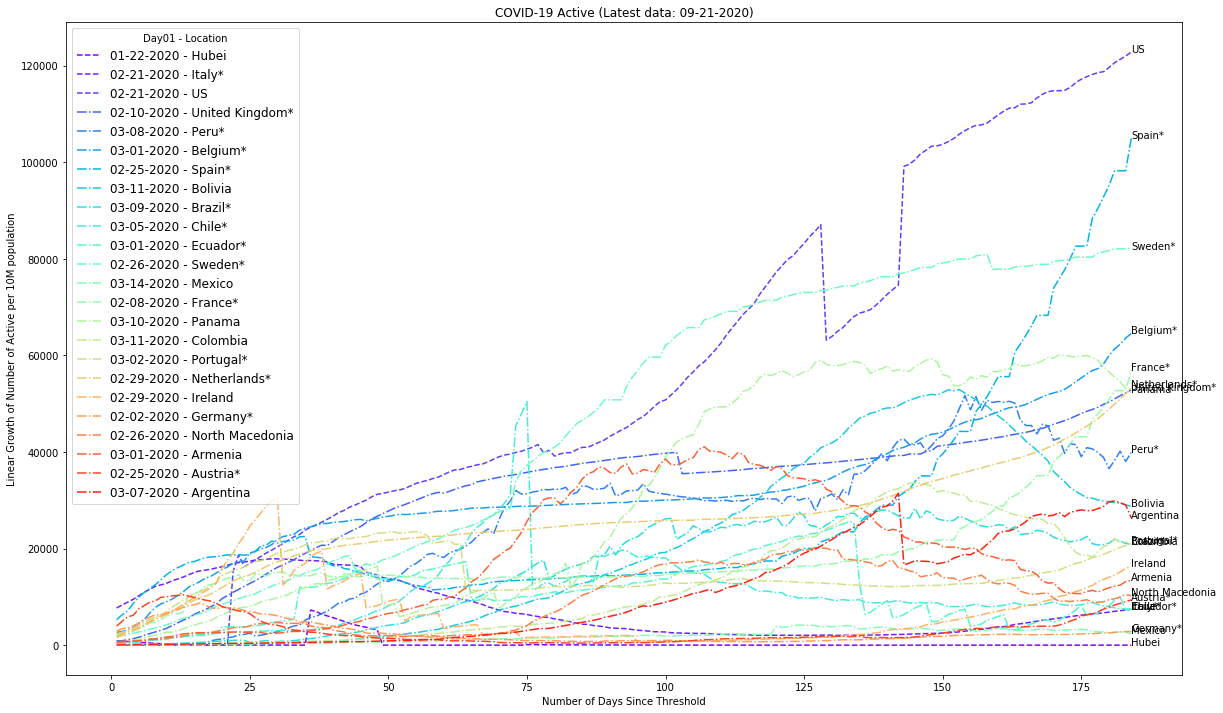

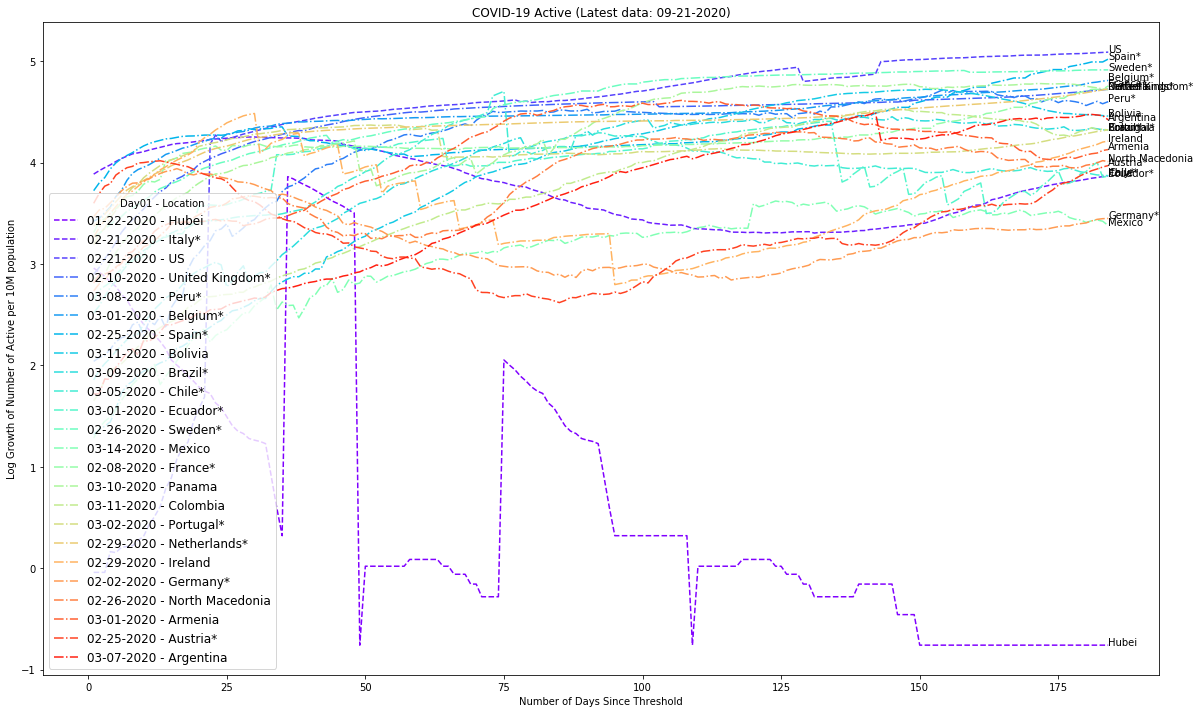

In [42]:
_plot_trend(global_deaths_trend, global_top_deaths_locs, 'Active')
_plot_log_trend(global_deaths_trend, global_top_deaths_locs, 'Active', leg_loc = "lower left")